In [1]:
import importlib
import torch
import torch.nn as nn
import itertools
from collections import OrderedDict 
import onnx
import tvm
from onnx import shape_inference

import op_constraint as opc
import op_projection as opp
import random_graph as rg
import utility
import graph_debug as gd
import networkx as nx
import matplotlib.pyplot as plt


In [7]:
importlib.reload(rg)  #Reload a previously imported module
importlib.reload(opc)
importlib.reload(opp)
importlib.reload(utility)
importlib.reload(gd)

<module 'graph_debug' from '/home/newuser/ruochen_workspace/TVMGraphFuzzer/Fuzzer/graph_generator/graph_debug.py'>

In [2]:

graph_gen_parameter = {
    "node_num":5, 
    "graph_mode":"ER", 
    "p":0.3
}

input_shapes = [[1, 3, 224, 224], [1, 6, 112, 112], [1, 12, 56, 56], [1, 24, 28, 28]]
output_shapes = [[1, 6, 112, 112], [1, 12, 56, 56], [1, 24, 28, 28], [1, 36, 14, 14]]
input_shapes = input_shapes[:3]
output_shapes = output_shapes[:3]


In [3]:
'''generate RandomGraph object'''
graph1=rg.RandomGraph(**graph_gen_parameter)
print(graph1.graph_param)    
#node_num and graph_mode are accepted by the two args on the left
#p is accepted by the **graph_param.  graph_param in the RandomGraph is dict {'p': 0.3}

'''output
{'p': 0.3}
'''


{'p': 0.3}


In [6]:
#test **dict
def fun(a,b):
    print(f'a is {a}')
    print(f'b is {b}')

# keyword={'a':'01','b':'02','c':'03'}  #if the dict has the arg undefined in fun, assert error
# print(keyword)
# fun(**keyword)

keyword={'a':'01','b':'02'}
print(keyword)
fun(**keyword)

'''output
{'a': '01', 'b': '02'}
a is 01
b is 02
'''

{'a': '01', 'b': '02'}
a is 01
b is 02


In [7]:
#test **dict
def fun(a,b,**args):
  print(f'a is {a}')
  print(f'b is {b}')
  print(f'args is {args}')

input={'a':1,'b':2,'c':3,'d':4}
fun(**input)

'''output
a is 1
b is 2
args is {'c': 3, 'd': 4}
'''

a is 1
b is 2
args is {'c': 3, 'd': 4}


In [28]:
'''generate graph'''
graph1._random_graph_generator() #graph_mode is ER
#print(graph1.graph)


In [24]:
graph1.graph.nodes

'''
NodeView((0, 1, 2, 3, 4))
'''


NodeView((0, 1, 2, 3, 4))

In [22]:
graph1.graph.edges
''' 
EdgeView([(0, 1), (0, 3), (0, 4), (1, 2)])
'''

EdgeView([(0, 1), (0, 3), (0, 4), (1, 2)])

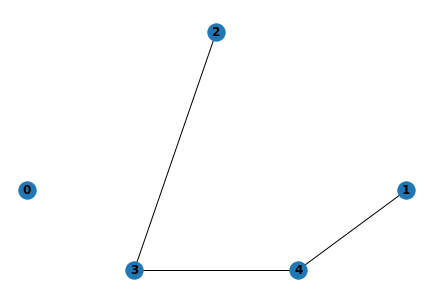

In [29]:
nx.draw_shell(graph1.graph, nlist=[range(2, 5), range(2)], with_labels=True, font_weight='bold')
#ER doesn't generate 

In [26]:
'''parse_graph()'''
#it adds an input and an output nodes
#
nodes,edges=rg.RandomGraph.parse_graph(graph1.graph)
print(nodes)
print(edges)

'''
[0, 1, 2, 3, 4, 5, 6]
OrderedDict([(0, []), (1, [0]), (2, [0]), (3, [2]), (4, [3]), (5, [2]), (6, [1, 4, 5])])
'''

node 0's neighbor is []
node 1's neighbor is [2, 4]
node 2's neighbor is [1, 3]
node 3's neighbor is [2]
node 4's neighbor is [1]
[0, 1, 2, 3, 4, 5, 6]
OrderedDict([(0, []), (1, [0]), (2, [0]), (3, [2]), (4, [3]), (5, [2]), (6, [1, 4, 5])])


In [35]:
'''test OrderedDict()'''
edge=OrderedDict()
edge[0]=[]    #0 is key
edge['1']=2   #'1' is key
print(edge)
print(edge['1'])

OrderedDict([(0, []), ('1', 2)])
2


In [10]:
# test constraint
import constraint

problem = constraint.Problem()

problem.addVariable('x', [1,2,3])
problem.addVariable('y', range(10))

def our_constraint(x, y):
    if x + y >= 5:
        return True

problem.addConstraint(our_constraint, ['x','y'])

solutions = problem.getSolutions()

print(f'solutions are {solutions}') #a list, elements are dict
print('-------------------------------')
print(f'enumerate solutions are {enumerate(solutions)}')
print('-----------------------------------')
# print(f'enumerate(solutions)[0] are {enumerate(solutions)[0]}') #can't substriptable
# print('-----------------------------------')
i=0
for a in enumerate(solutions): 
    print(f'the {i}th solution is {a}')   #tuple (0, {'x': 3, 'y': 9}). i.e. change list to a tuple (index,element)
    i=i+1
print('------------------------------------')

# Easier way to print and see all solutions
# for solution in solutions:
#    print(solution)

# Prettier way to print and see all solutions
length = len(solutions)
print("(x,y) ∈ {", end="")
for index, solution in enumerate(solutions):
    if index == length - 1:
        print("({},{})".format(solution['x'], solution['y']), end="")
    else:
        print("({},{}),".format(solution['x'], solution['y']), end="")
print("}")

solutions are [{'x': 3, 'y': 9}, {'x': 3, 'y': 8}, {'x': 3, 'y': 7}, {'x': 3, 'y': 6}, {'x': 3, 'y': 5}, {'x': 3, 'y': 4}, {'x': 3, 'y': 3}, {'x': 3, 'y': 2}, {'x': 2, 'y': 9}, {'x': 2, 'y': 8}, {'x': 2, 'y': 7}, {'x': 2, 'y': 6}, {'x': 2, 'y': 5}, {'x': 2, 'y': 4}, {'x': 2, 'y': 3}, {'x': 1, 'y': 9}, {'x': 1, 'y': 8}, {'x': 1, 'y': 7}, {'x': 1, 'y': 6}, {'x': 1, 'y': 5}, {'x': 1, 'y': 4}]
-------------------------------
enumerate solutions are <enumerate object at 0x7f1a94afa6e0>
-----------------------------------
the 0th solution is (0, {'x': 3, 'y': 9})
the 1th solution is (1, {'x': 3, 'y': 8})
the 2th solution is (2, {'x': 3, 'y': 7})
the 3th solution is (3, {'x': 3, 'y': 6})
the 4th solution is (4, {'x': 3, 'y': 5})
the 5th solution is (5, {'x': 3, 'y': 4})
the 6th solution is (6, {'x': 3, 'y': 3})
the 7th solution is (7, {'x': 3, 'y': 2})
the 8th solution is (8, {'x': 2, 'y': 9})
the 9th solution is (9, {'x': 2, 'y': 8})
the 10th solution is (10, {'x': 2, 'y': 7})
the 11th solut

In [11]:
dir(opc.Conv2d)

['_C_constraint',
 '_H_constraint',
 '_W_constraint',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_param_conversion',
 'get_node',
 'get_possible_params',
 'get_split_info',
 'input_conversion']

In [2]:
# test dict defined in function
def fun():
    a={}
    a['ruochen']='handsome boy'
    print(f'inside fun, a is {a}')

fun()
print(f'outside fun, a is {a}')   #not defined a

inside fun, a is {'ruochen': 'handsome boy'}


NameError: name 'a' is not defined

In [5]:
a={1:100,'b':1000}
print(a[1])

100


In [16]:
# test get_sub_graph
rg.get_sub_graph(input_shapes[0],output_shapes[0],**graph_gen_parameter)

node 0's neighbor is []
node 1's neighbor is [2, 3]
node 2's neighbor is [1, 3, 4]
node 3's neighbor is [1, 2]
node 4's neighbor is [2]
input_cell is Conv2d(3, 6, kernel_size=(1, 4), stride=(2, 2), padding=(0, 1))
cell_graph is (ModuleList(
  (0): ConvTranspose2d(6, 6, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1), bias=False)
  (1): SplitWrapper()
  (2): GroupNorm(2, 6, eps=0.01, affine=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): GroupNorm(3, 6, eps=0.0001, affine=True)
  (5): GroupNorm(3, 6, eps=0.1, affine=True)
  (6): CatWrapper()
  (7): LogSigmoid()
), OrderedDict([(1, [0]), (2, [1]), (3, [2]), (4, [2]), (5, [2]), (6, [2]), (7, [3, 4, 5, 6]), (8, [7])]), OrderedDict([(1, [None]), (2, [None]), (3, [0]), (4, [1]), (5, [2]), (6, [3]), (7, [None, None, None, None]), (8, [None])]), OrderedDict([(0, [[1, 6, 112, 112]]), (1, [[1, 6, 112, 112]]), (2, [[1, 6, 112, 112]]), (3, [[1, 6, 112, 28]]), (4, [[1, 6, 112, 28]]), (5, [[1, 6, 112, 28]]), (6, [[1, 6, 112, 28]]), (7, [[1, 6, 1

TestSubgraph(
  (input_cell): Conv2d(3, 6, kernel_size=(1, 4), stride=(2, 2), padding=(0, 1))
  (normal_cell_list): ModuleList(
    (0): Cell(
      (subnode_list): ModuleList(
        (0): ConvTranspose2d(6, 6, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1), bias=False)
        (1): SplitWrapper()
        (2): GroupNorm(2, 6, eps=0.01, affine=True)
        (3): Dropout(p=0.2, inplace=False)
        (4): GroupNorm(3, 6, eps=0.0001, affine=True)
        (5): GroupNorm(3, 6, eps=0.1, affine=True)
        (6): CatWrapper()
        (7): LogSigmoid()
      )
    )
    (1): Cell(
      (subnode_list): ModuleList(
        (0): ConvTranspose2d(6, 6, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1), bias=False)
        (1): SplitWrapper()
        (2): GroupNorm(2, 6, eps=0.01, affine=True)
        (3): Dropout(p=0.2, inplace=False)
        (4): GroupNorm(3, 6, eps=0.0001, affine=True)
        (5): GroupNorm(3, 6, eps=0.1, affine=True)
        (6): CatWrapper()
        (7): LogSigmoid()
    

In [27]:
# getattr

import test_getattr
print(f'a is {a}')
print(f'a in test_getattr.py is {test_getattr.a}')

b=getattr(test_getattr,test_getattr.a)()
print(f'class GetattrTest\'s instance b is {b}')



a is OrderedDict([(1, [1, 1, 1]), (2, [2, 2, 2])])
a in test_getattr.py is GetattrTest
hello
class GetattrTest's instance b is <test_getattr.GetattrTest object at 0x7f761a645610>


In [2]:
print([i for i in range(2,4)])

[2, 3]


In [3]:
# test variables defined in for
for a in range(5):
    b=a

print(b)

4


In [11]:
#test range(2,2)
for a in range(2,2):
    b=a
    print(f'b is {b}')

In [24]:
#test SplitCat class
splitcat_node=opc.SplitCat()
node_constraint={"input_shape":[64,3,64,64]}
result=splitcat_node.get_possible_params(node_constraint)
        
print(f'node_constraint is {node_constraint}\ncorresponding result is {result}')
print('---------------------------------------------------------------')

for i in range(len(result)):
    print(f'input_shape is {node_constraint["input_shape"]}')
    layout_info=splitcat_node.get_layout_info(param=result[i],shape=node_constraint["input_shape"])
    print(f'result[{i}] is {result[i]}')
    print(f'layout_info is {layout_info}')
    print("--------------------------------------------------")



node_constraint is {'input_shape': [64, 3, 64, 64]}
corresponding result is [{'split_size_or_sections': 32, 'dim': 2}, {'split_size_or_sections': 21, 'dim': 2}, {'split_size_or_sections': 16, 'dim': 2}, {'split_size_or_sections': 32, 'dim': 3}, {'split_size_or_sections': 21, 'dim': 3}, {'split_size_or_sections': 16, 'dim': 3}]
---------------------------------------------------------------
input_shape is [64, 3, 64, 64]
result[0] is {'split_size_or_sections': 32, 'dim': 2}
layout_info is [[64, 3, 32, 64], [64, 3, 32, 64]]
--------------------------------------------------
input_shape is [64, 3, 64, 64]
result[1] is {'split_size_or_sections': 21, 'dim': 2}
layout_info is [[64, 3, 21, 64], [64, 3, 21, 64], [64, 3, 21, 64], [64, 3, 1, 64]]
--------------------------------------------------
input_shape is [64, 3, 64, 64]
result[2] is {'split_size_or_sections': 16, 'dim': 2}
layout_info is [[64, 3, 16, 64], [64, 3, 16, 64], [64, 3, 16, 64], [64, 3, 16, 64]]
---------------------------------

In [8]:
# test get_cell
subnode_list, cell_topology, split_tree, shape_info=opp.get_cell([64,3,64,64])
print(f'subnode_list is {subnode_list}')
print('-----------------------------------')
'''
cell_topology is OrderedDict([(1, [0]), (2, [1]), (3, [1]), (4, [1]), (5, [1]), (6, [2]), (7, [3]), (8, [4]), (9, [5]), (10, [6, 7, 8, 9]), (11, [10])])

split_tree is OrderedDict([(1, [None]), (2, [0]), (3, [1]), (4, [2]), (5, [3]), (6, [None]), (7, [None]), (8, [None]), (9, [None]), (10, [None, None, None, None]), (11, [None])])

shape_info is OrderedDict([(0, [[64, 3, 64, 64]]), (1, [[64, 3, 64, 64]]), (2, [[64, 3, 64, 16]]), (3, [[64, 3, 64, 16]]), (4, [[64, 3, 64, 16]]), (5, [[64, 3, 64, 16]]), (6, [[64, 3, 64, 16]]), (7, [[64, 3, 64, 16]]), (8, [[64, 3, 64, 16]]), (9, [[64, 3, 64, 16]]), (10, [[64, 3, 64, 16], [64, 3, 64, 16], [64, 3, 64, 16], [64, 3, 64, 16]]), (11, [[64, 3, 64, 64]])])

op_phase is [-1, 1, 1, 1, 1, 2, 2, 2, 2, -2, 3]

subnode_list is ModuleList(
  (0): SplitWrapper()
  (1): Linear(in_features=16, out_features=16, bias=True)
  (2): Sequential(
    (Conv): Conv2d(3, 3, kernel_size=(5, 3), stride=(1, 1), padding=(2, 2), dilation=(1, 2), groups=3, bias=False)
    (pointwiseConv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (3): ConvTranspose2d(3, 3, kernel_size=(7, 3), stride=(1, 1), padding=(3, 1))
  (4): ConvTranspose2d(3, 3, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (5): BatchNorm2d(3, eps=1e-05, momentum=0.2, affine=False, track_running_stats=True)
  (6): BatchNorm2d(3, eps=0.01, momentum=0.30000000000000004, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): GroupNorm(3, 3, eps=0.0001, affine=True)
  (9): CatWrapper()
  (10): Sigmoid()
)
)

the corresponding op_phase is [-1, 1, 1, 1, 1, 2, 2, 2, 2, -2, 3]
'''

print(f'cell_topology is {cell_topology}')
print('-----------------------------------')
print(f'split_tree is {split_tree}')
print('-----------------------------------')
print(f'shape_info is {shape_info}')
print('-----------------------------------')

----------------------
cell_topology is OrderedDict([(1, [0]), (2, [1]), (3, [1]), (4, [1]), (5, [1]), (6, [2]), (7, [3]), (8, [4]), (9, [5]), (10, [6, 7, 8, 9]), (11, [10])])
split_tree is OrderedDict([(1, [None]), (2, [0]), (3, [1]), (4, [2]), (5, [3]), (6, [None]), (7, [None]), (8, [None]), (9, [None]), (10, [None, None, None, None]), (11, [None])])
shape_info is OrderedDict([(0, [[64, 3, 64, 64]]), (1, [[64, 3, 64, 64]]), (2, [[64, 3, 64, 16]]), (3, [[64, 3, 64, 16]]), (4, [[64, 3, 64, 16]]), (5, [[64, 3, 64, 16]]), (6, [[64, 3, 64, 16]]), (7, [[64, 3, 64, 16]]), (8, [[64, 3, 64, 16]]), (9, [[64, 3, 64, 16]]), (10, [[64, 3, 64, 16], [64, 3, 64, 16], [64, 3, 64, 16], [64, 3, 64, 16]]), (11, [[64, 3, 64, 64]])])
op_phase is [-1, 1, 1, 1, 1, 2, 2, 2, 2, -2, 3]

subnode_list is ModuleList(
  (0): SplitWrapper()
  (1): Linear(in_features=16, out_features=16, bias=True)
  (2): Sequential(
    (Conv): Conv2d(3, 3, kernel_size=(5, 3), stride=(1, 1), padding=(2, 2), dilation=(1, 2), groups=

In [11]:
#test lambda
def LambdaTest(a,b):
    return lambda c,d,e,f: a+b+c+d+e+f


print(f'LambdaTest(a=1,b=2) is {LambdaTest(a=1,b=2)}')
print('-------------------------------------')
print(f'LambdaTest(a=1,b=2)(c=3,d=4,e=5,f=6) is {LambdaTest(a=1,b=2)(c=3,d=4,e=5,f=6)}')

LambdaTest(a=1,b=2) is <function LambdaTest.<locals>.<lambda> at 0x7fe5b8569dd0>
-------------------------------------
LambdaTest(a=1,b=2)(c=3,d=4,e=5,f=6) is 21
